In [1]:
import networkx as nx
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.random import rand
from numpy import exp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
G = nx.read_gml("municipios_br.gml")
G = nx.relabel_nodes(G,lambda x: int(x))

In [3]:
data_dict = dict(G.nodes.data("CD_MUN"))

In [4]:
data = pd.read_csv('caso_full.csv')

In [5]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
a = ['city_ibge_code','order_for_place','date','epidemiological_week',
 'last_available_confirmed_per_100k_inhabitants','last_available_confirmed',
 'last_available_death_rate']
columns_to_drop = ['state','city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                  'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data.epidemiological_week -= data.epidemiological_week.min()

In [6]:
grouped = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","date"]].groupby('city_ibge_code')

In [7]:
n = data["city_ibge_code"].nunique()
codes = data["city_ibge_code"].unique()

In [8]:
min_date = data["date"].min()
max_date = data["date"].max()

In [9]:
max_date

Timestamp('2021-10-07 00:00:00')

In [10]:
delta = max_date - min_date

In [11]:
dates = pd.date_range(start=min_date, end=max_date, freq='D')
i = 0
X = np.zeros((len(grouped),delta.days + 1))
for group, data in grouped:
    series = data[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    shape = series.shape
    X[i,:] = series.values.reshape(len(series))
    if data_dict[i] != str(group)[:-2]:
        print(data_dict[i],group)
    i += 1

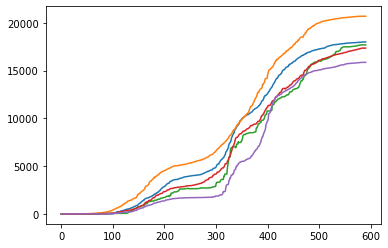

In [12]:
for i in range(5):
    plt.plot(X[i,:])
plt.show()

In [13]:
zeros = np.zeros(len(grouped), dtype=bool)
true_indices = np.random.choice(len(grouped),2)
np.put(zeros,true_indices,True)
zeros

array([False, False, False, ..., False, False, False])

In [14]:
#aqui geramos um candidato com base nos nodes possiveis simplesmente escolhendo um para entrar
def gen_candidate_no_constraint(nodes,curr):
    candidate = curr
    curr_idx = np.nonzero(curr)[0]
    leave_basis = np.random.choice(curr_idx)
    candidate[leave_basis] = False
    #enter_basis = np.random.choice(np.where(candidate == False)[0],1)
    enter_basis = np.random.choice(np.append(nodes,leave_basis),1)
    candidate[enter_basis] = True
    return candidate

In [15]:
#aqui geramos um candidato com base nos nodes possiveis escolhendo um para entrar e outro para sair 
#até satisfazer a restrição
def gen_candidate_with_constraint(G,nodes,curr,mask):
    candidate = gen_candidate_no_constraint(nodes,curr.copy())
    change = candidate.astype(np.float32) - curr.astype(np.float32)
    try:
        enter_basis = np.where(change == 1)[0][0]
        leave_basis = np.where(change == -1)[0][0]
    except:
        print((candidate==curr).all())
        return candidate
    curr_idx = np.nonzero(candidate)[0]
    SG = G.subgraph(curr_idx)
    while not nx.is_connected(SG):
        candidate = gen_candidate_no_constraint(nodes,curr.copy())
        curr_idx = np.nonzero(candidate)[0]
        SG = G.subgraph(curr_idx)
    mask[[n for n in G.neighbors(leave_basis)]] = False
    mask[leave_basis] = False
    mask[[n for n in G.neighbors(enter_basis)]] = True
    mask[enter_basis] = True
    return candidate

In [16]:
False - True

-1

In [17]:
a = np.array([1,2,3])
b = np.array([12,3])
a[~np.isin(a,b)]

array([1, 2])

In [18]:
#aqui geramos um candidato selecionando um vertice aleatoriamente para sair e incluindo um de seus vizinhos
def gen_candidate_with_constraint2(G,curr):
    candidate = curr.copy()
    curr_idx = np.nonzero(curr)[0]
    leave_basis = np.random.choice(curr_idx)
    nodes = np.array([n for n in G.neighbors(leave_basis)])
    enter_basis = np.random.choice(np.append(nodes[~np.isin(nodes,curr_idx)],leave_basis),1)
    candidate[leave_basis] = False
    candidate[enter_basis] = True
    SG = G.subgraph(candidate)
    if nx.is_connected(SG):
        return candidate
    else:
        return curr

In [19]:
def reachble_nodes(G,curr_idx,mask):
    U = set()
    queuque = list(curr_idx)
    while len(queuque) > 0:
        v = queuque.pop(0)
        if v not in U:
            U.add(v)
            neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
            queuque.extend(neighbors)
    mask[list(U)] = True
    return mask

In [20]:
a = np.array([1,2,3])
mask = np.where(a==2,True,False)
a[mask],a

(array([2]), array([1, 2, 3]))

In [21]:
def generate_candidate(nodes,curr,mask,constraint=False,method=1):
    curr_idx = np.nonzero(curr)[0]
    if constraint and method==1:
        ##Nesse caso mask será utilizado para denotar o conjunto dos vértices alcançáveis
        if (curr == mask).all():
            mask = reachble_nodes(G,curr_idx,mask)
        mask[curr_idx] = False
        return gen_candidate_with_constraint(G,nodes[mask],curr,mask)
    elif constraint and method==2:
        candidate = gen_candidate_with_constraint2(G,curr)
        return candidate
    else:
        possible_choices = nodes[~np.isin(nodes,curr_idx)]
        return gen_candidate_no_constraint(possible_choices,curr)

In [22]:
def powerLaw(T,i):
    return T*(0.995**i) 
def linear(T,i):
    return T - 10*i/9 + 1e-5
def log(T,i):
    return T/np.log(i+np.e) - 250*i/1800
update_strategies = [powerLaw,linear,log]

In [23]:
def generate_candidate0(len_x,k,constraint=False):
    best = np.zeros(len_x, dtype=bool)
    if constraint:
        ini = np.random.choice(len_x,1)[0]
        U = set()
        queuque = [ini]
        total = 0
        while total < k:
            v = queuque.pop(0)
            if v not in U:
                U.add(v)
                total += 1
                neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
                queuque.extend(neighbors)
        np.put(best,list(U),True)
        return best
    else:
        true_indices = np.random.choice(len_x,k)
        np.put(best,true_indices,True)
        return best

In [24]:
def objective(X,choice):
    return -np.linalg.slogdet(np.cov(X[choice,:]))[1]

# simulated annealing algorithm
def simulated_annealing(objective, n_iterations, temp, X, k,update_estrategy=linear,constraint=False,ini=[],method=2):
    # generate an initial point
    len_x = X.shape[0]
    nodes = np.arange(len_x)
    best = ini
    if len(best) == 0:
        best = generate_candidate0(len_x,k,constraint)
    values = []
    # evaluate the initial point
    best_eval = objective(X,best)
    # current working solution
    curr, curr_eval = best, best_eval
    # run the algorithm
    mask = curr.copy()
    for i in tqdm(range(n_iterations)):
        # take a step
        candidate = generate_candidate(nodes,curr,mask,constraint,method)
        # evaluate candidate point
        candidate_eval = objective(X.copy(),candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            values.append(best_eval)
            #print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = update_estrategy(temp,i)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval, values]

In [25]:
# define the total iterations
n_iterations = 1800
# initial temperature
temp = 2000
k = 557
len_x = X.shape[0]
ini = generate_candidate0(len_x,k,False)

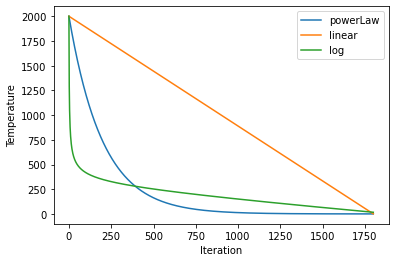

In [26]:
iters = np.arange(1800)
for s in update_strategies:
    v = np.vectorize(s)
    t = v(temp,iters)
    plt.plot(t,label=s.__name__)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Temperature")
plt.show()

-2860.140803416004 powerLaw


100%|███████████████████████████████████████| 1800/1800 [00:32<00:00, 54.78it/s]


-2860.140803416004 linear


100%|███████████████████████████████████████| 1800/1800 [00:32<00:00, 55.76it/s]


-2860.140803416004 log


100%|███████████████████████████████████████| 1800/1800 [00:31<00:00, 56.85it/s]


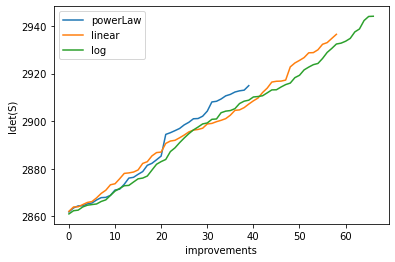

In [54]:
all_best = []
all_eval = 0
ini = generate_candidate0(len_x,k,False)
for estrategy in update_strategies:
    Y = X.copy()
    print(objective(Y,ini),estrategy.__name__)
    best, best_eval, values = simulated_annealing(objective, n_iterations, temp, Y, k,
                                                  update_estrategy=estrategy,ini=ini.copy())
    plt.plot(np.abs(values),label=estrategy.__name__)
    if all_eval < abs(best_eval):
        all_eval = best_eval
        all_best = best
plt.xlabel('improvements')
plt.ylabel('ldet(S)')
plt.legend()
plt.show()

In [55]:
#!pip install libpysal
#!pip install geopandas
import geopandas as gpd
municipios = gpd.read_file('BR_Municipios_2020/BR_Municipios_2020.shp')
m = municipios.geometry.to_crs(epsg=5641)
centroids = np.column_stack((m.centroid.x, m.centroid.y))
positions = dict(zip(G.nodes, centroids))

In [56]:
color_map = []
idx = np.nonzero(all_best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

In [57]:
all_best

array([False, False, False, ..., False, False, False])

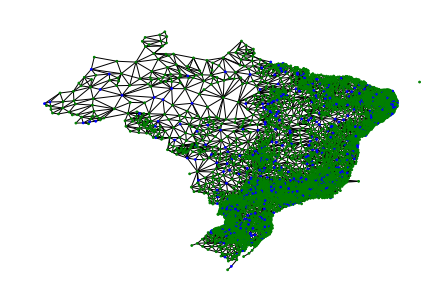

In [58]:
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [45]:
nx.is_connected(G.subgraph(np.nonzero(best)[0])) 

False

-2516.331345766757 powerLaw


100%|███████████████████████████████████████| 1800/1800 [01:11<00:00, 25.26it/s]


True
-2516.331345766757 linear


100%|███████████████████████████████████████| 1800/1800 [01:14<00:00, 24.09it/s]


True
-2516.331345766757 log


100%|███████████████████████████████████████| 1800/1800 [01:03<00:00, 28.40it/s]


True


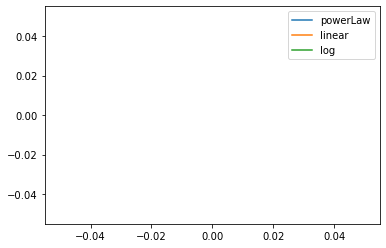

In [46]:
ini = generate_candidate0(len_x,k,True)
all_best = []
all_eval = 0
for estrategy in update_strategies:
    Y = X.copy()
    print(objective(Y,ini),estrategy.__name__)
    best, best_eval, values = simulated_annealing(objective, n_iterations, temp, Y, k,
                                                  update_estrategy=estrategy,constraint=True,
                                                  ini=ini.copy(),method=2)
    plt.plot(np.abs(values),label=estrategy.__name__)
    print(nx.is_connected(G.subgraph(np.nonzero(best)[0])))
    if all_eval < abs(best_eval):
        all_eval = best_eval
        all_best = best
plt.legend()
plt.show()

In [47]:
best_eval

-2516.331345766757

In [48]:
color_map = []
idx = np.nonzero(all_best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

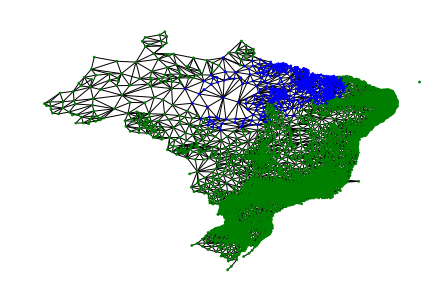

In [49]:
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

-2634.2862873204604 powerLaw


100%|███████████████████████████████████████| 1800/1800 [13:13<00:00,  2.27it/s]


True
-2634.2862873204604 linear


100%|███████████████████████████████████████| 1800/1800 [12:01<00:00,  2.49it/s]


True
-2634.2862873204604 log


 69%|███████████████████████████            | 1247/1800 [08:56<03:43,  2.47it/s]

True


100%|███████████████████████████████████████| 1800/1800 [13:49<00:00,  2.17it/s]

True


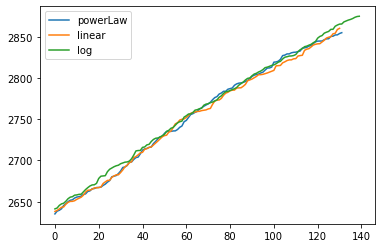

In [50]:
ini = generate_candidate0(len_x,k,True)
all_best = []
all_eval = 0
for estrategy in update_strategies:
    Y = X.copy()
    print(objective(Y,ini),estrategy.__name__)
    best, best_eval, values = simulated_annealing(objective, n_iterations, temp, Y, k,
                                                  update_estrategy=estrategy,constraint=True,
                                                  ini=ini.copy(),method=1)
    plt.plot(np.abs(values),label=estrategy.__name__)
    print(nx.is_connected(G.subgraph(np.nonzero(best)[0])))
    if all_eval < abs(best_eval):
        all_eval = best_eval
        all_best = best
plt.legend()
plt.show()

In [51]:
color_map = []
idx = np.nonzero(all_best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

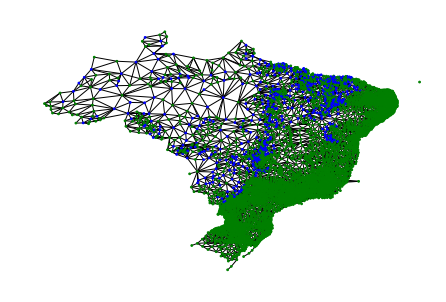

In [52]:
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [53]:
print(nx.is_connected(G.subgraph(np.nonzero(all_best)[0])))

True
